# Modelo de Deep Learning para detectar tumores de cerebro

## Integrantes:
* Edison Naranjo
* Berenice Arguero
* Marcela Mosquera

## Importación  de las librerías requeridas

In [ ]:
# Instalación de Tensorflow
# =========================

! pip install tensorflow -U

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## Carga de Datos

Se cargará los datos desde Google Drive

In [ ]:
# Cargar datos desde Google Drive
# ===============================

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Funciones para obtener los dataframes de entrenamiento y prueba con la ruta de la imagen y la clase a la que pertenece

In [ ]:
# Función llamada test_df que toma un argumento ts_path, el cual es la ruta
# al directorio raíz que contiene las subcarpetas de las diferentes clases
# de imágenes.

def test_df(ts_path):

  # Se inicializan dos listas vacías: classes para almacenar las etiquetas de
  # las clases y class_paths para almacenar las rutas completas de las imágenes.

  classes = []
  class_paths = []

  # Variable para obtener una lista de los nombres de las subcarpetas en el
  # directorio ts_path. Cada subcarpeta se asume que representa una clase diferente.

  files = os.listdir(ts_path)

  # Iteración a través de las Subcarpetas y Archivos

  for file in files:

    # Ruta completa a la subcarpeta.

    label_dir = os.path.join(ts_path, file)

    # Lista de todos los archivos (imágenes) en la subcarpeta.

    label = os.listdir(label_dir)

    # Se itera sobre cada archivo de imagen en label.

    for image in label:

      # Ruta completa a la imagen.

      image_path = os.path.join(label_dir, image)

      # Añade la ruta de la imagen a la lista class_paths.

      class_paths.append(image_path)

      # Añade la etiqueta de la clase (nombre de la subcarpeta) a la lista classes.

      classes.append(file)

  # Se crea una Serie de Pandas con las etiquetas de clase, nombrada 'Class'.

  image_classes = pd.Series(classes, name='Class')

  # Se crea una Serie de Pandas con las rutas de las imágenes, nombrada 'Class Path'.

  image_paths = pd.Series(class_paths, name='Class Path')

  # Combina las dos Series en un DataFrame de Pandas a lo largo del eje de columnas (axis=1).

  ts_df = pd.concat([image_paths, image_classes], axis=1)

  # Se devuelve el DataFrame resultante.

  return ts_df

La explicación es la misma para la función **train_df**

In [ ]:

def train_df(tr_path):
  classes = []
  class_paths = []
  files = os.listdir(tr_path)

  for file in files:
    label_dir = os.path.join(tr_path, file)
    label = os.listdir(label_dir)
    for image in label:
      image_path = os.path.join(label_dir, image)
      class_paths.append(image_path)
      classes.append(file)

  image_classes = pd.Series(classes, name='Class')
  image_paths = pd.Series(class_paths, name='Class Path')
  tr_df = pd.concat([image_paths, image_classes], axis=1)
  return tr_df

In [ ]:
# La variable tr_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Training

tr_df = train_df(tr_path="/content/drive/MyDrive/Tumor_Brain/Training")

In [ ]:
print(f"El dataframe de entranemiento tiene {tr_df.shape[0]} filas y {tr_df.shape[1]} columnas")

El dataframe de entranemiento tiene 5712 filas y 2 columnas


In [ ]:
# Cinco primeras filas del dataframe tr_df

tr_df.head()

,Class Path,Class
0,/content/drive/MyDrive/Tumor_Brain/Training/no...,notumor
1,/content/drive/MyDrive/Tumor_Brain/Training/no...,notumor
2,/content/drive/MyDrive/Tumor_Brain/Training/no...,notumor
3,/content/drive/MyDrive/Tumor_Brain/Training/no...,notumor
4,/content/drive/MyDrive/Tumor_Brain/Training/no...,notumor


In [ ]:
# La variable ts_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Testing

ts_df = test_df('/content/drive/MyDrive/Tumor_Brain/Testing')

In [ ]:
print(f"El dataframe de entranemiento tiene {ts_df.shape[0]} filas y {ts_df.shape[1]} columnas")

El dataframe de entranemiento tiene 1311 filas y 2 columnas


In [ ]:
ts_df.head()

,Class Path,Class
0,/content/drive/MyDrive/Tumor_Brain/Testing/men...,meningioma
1,/content/drive/MyDrive/Tumor_Brain/Testing/men...,meningioma
2,/content/drive/MyDrive/Tumor_Brain/Testing/men...,meningioma
3,/content/drive/MyDrive/Tumor_Brain/Testing/men...,meningioma
4,/content/drive/MyDrive/Tumor_Brain/Testing/men...,meningioma


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

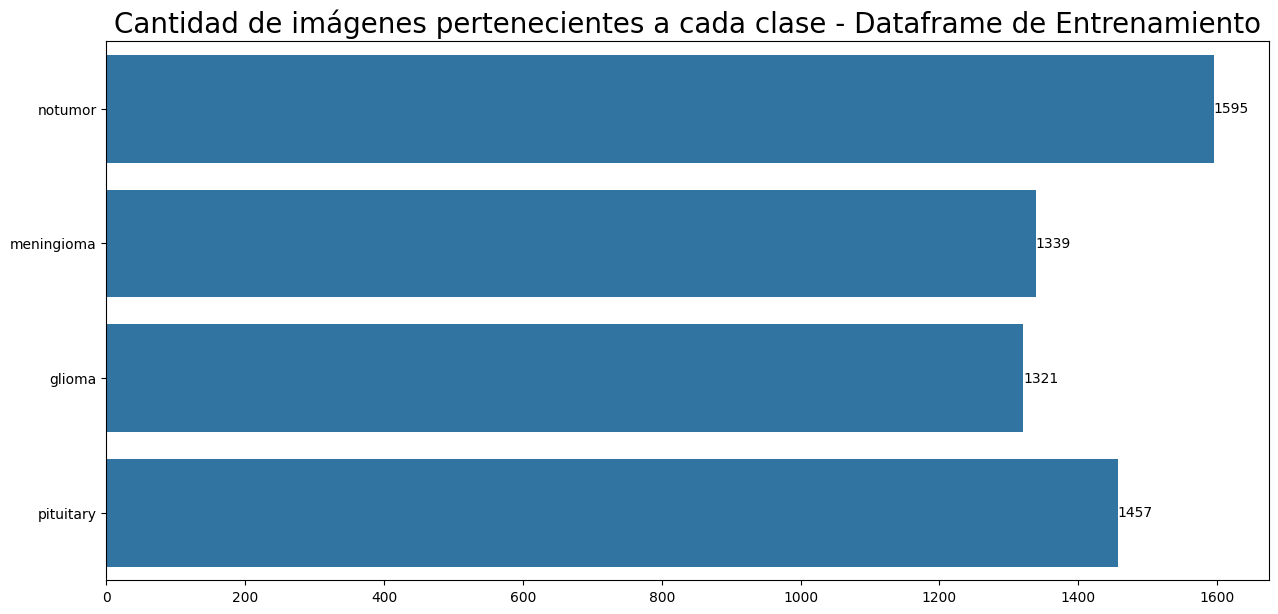

In [ ]:
# Cantidad de imágenes pertenecientes a cada clase - DataFrame de Entrenamiento
# =============================================================================

plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imágenes pertenecientes a cada clase - Dataframe de Entrenamiento', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

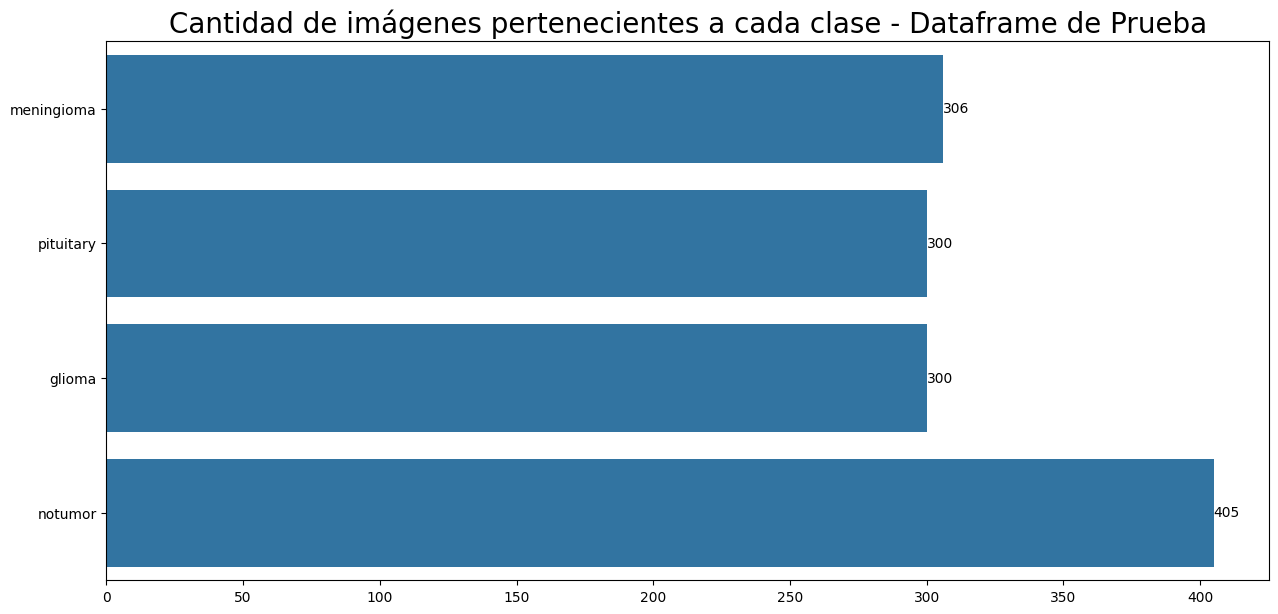

In [ ]:
# Cantidad de imágenes pertenecientes a cada clase - DataFrame de Prueba
# ======================================================================


plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imágenes pertenecientes a cada clase - Dataframe de Prueba', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

## División de los datos en entrenamiento, prueba y validación

In [ ]:
# El dataset de validación se obtiene diviendo la mitad del dataset de test

valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [ ]:
print(f"El dataframe de entranemiento tiene {valid_df.shape[0]} filas y {valid_df.shape[1]} columnas")

El dataframe de entranemiento tiene 655 filas y 2 columnas


## Preprocesamiento de Datos

ImageDataGenerator es una clase utilizada para generar lotes de tensores de imagen con aumentos de datos en tiempo real. Esto es muy útil para el entrenamiento de modelos de redes neuronales, ya que permite ampliar artificialmente el tamaño del dataset aplicando transformaciones aleatorias a las imágenes de entrenamiento.

In [ ]:
batch_size = 16
img_size = (299,299)

* __batch_size:__ define el número de imágenes que se procesarán en cada lote durante el entrenamiento. En este caso, el tamaño del lote es 16.
* __img_size:__ define el tamaño al que se redimensionarán todas las imágenes de entrada. Aquí, las imágenes se redimensionarán a 299x299 píxeles, que es el tamaño predeterminado de la imagen de entrada para este modelo.

In [ ]:
tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

* __ImageDataGenerator(brightness_range=(.8, 1.2)):__ crea un objeto ImageDataGenerator para el conjunto de entrenamiento. Este generador ajustará el brillo de las imágenes en un rango entre 0.8 y 1.2 del brillo original. Esto es una técnica de aumento de datos que ayuda a mejorar la generalización del modelo al exponerlo a diferentes condiciones de iluminación.

In [ ]:
gen = ImageDataGenerator()

* __ImageDataGenerator()__: crea un objeto ImageDataGenerator sin especificar ningún aumento de datos. Este generador se utilizará para los conjuntos de validación y prueba, donde generalmente no se desea aplicar aumentos para evaluar el rendimiento real del modelo.

### Flujo de imágenes de entrenamiento

In [ ]:
tr_gen = tr_gen.flow_from_dataframe(tr_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 5712 validated image filenames belonging to 4 classes.


* __tr_gen.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size):__ crea un flujo de datos de imágenes a partir de un DataFrame tr_df para el entrenamiento.

* __tr_df:__ DataFrame que contiene las rutas a las imágenes (Class Path) y sus etiquetas (Class).
* __x_col:__ nombre de la columna en el DataFrame que contiene las rutas de las imágenes.
* __y_col:__ nombre de la columna en el DataFrame que contiene las etiquetas de las imágenes.
* __batch_size:__ número de imágenes por lote.
* __target_size:__ tamaño al que se redimensionarán las imágenes.

### Flujo de imágenes de validación

In [ ]:
valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


* __valid_gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size):__ similar al anterior, pero para el conjunto de validación valid_df.

### Flujo de imágenes de prueba

In [ ]:
ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size,shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


* __ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size, shuffle=False):__ crea un flujo de datos de imágenes a partir de un DataFrame ts_df para el conjunto de prueba.
* __shuffle=False:__ asegura que las imágenes no se barajen, lo cual es útil para evaluar el rendimiento del modelo de manera consistente.

## Obtener Muestras de los datos

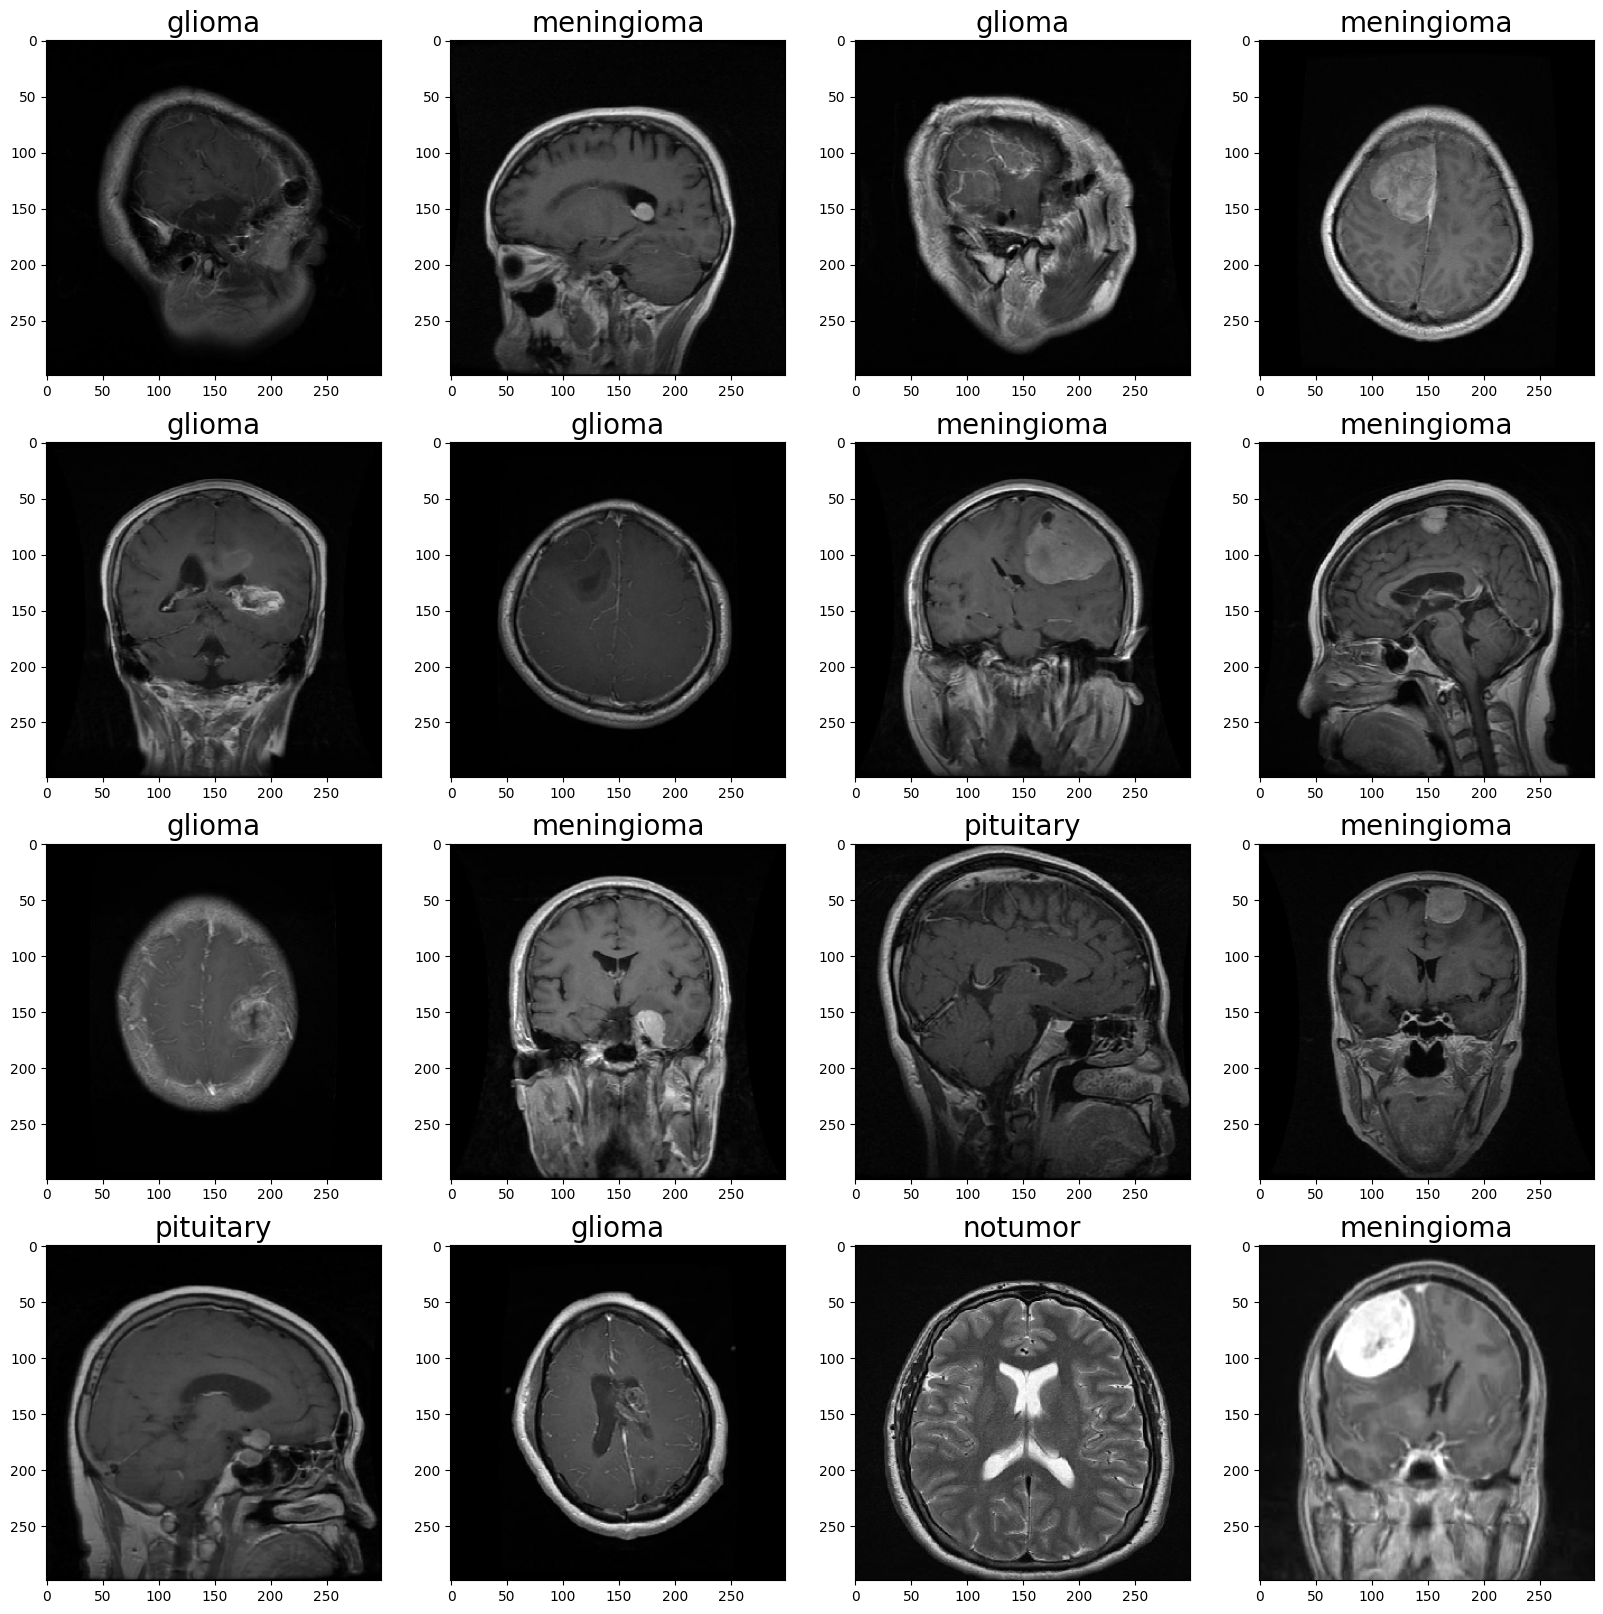

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)
plt.figure(figsize= (20, 20))
for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i] / 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color='k', fontsize=20)
plt.show()

## Creación del Modelo de Deep Learning

In [ ]:
# Definición de  las dimensiones de las imágenes de entrada:
# 299 píxeles de altura, 299 píxeles de ancho, y 3 canales de color (RGB).
# Este es el tamaño esperado por el modelo Xception.

img_shape=(299,299,3)

# Carga del Modelo Base

base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')


# tf.keras.applications.Xception carga el modelo Xception preentrenado.

# include_top=False excluye las capas superiores del modelo (las capas completamente conectadas originales),
# permitiendo personalizar la salida para un nuevo conjunto de clases.

# weights="imagenet" utiliza los pesos preentrenados en el conjunto de datos ImageNet.

# input_shape=img_shape define la forma de las entradas esperadas por el modelo.

# pooling='max' aplica una operación de max pooling global después de la última capa convolucional,
# reduciendo el tamaño de los datos a una representación de características de menor dimensión.



# Construcción del modelo
# =======================

# Tensor de entrada

input_tensor = tf.keras.Input(shape=img_shape)

# tf.keras.Input(shape=img_shape) crea un tensor de entrada para el modelo con la forma
# especificada por img_shape.


x = base_model(input_tensor)
x = Flatten()(x)
x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)

# x = base_model(input_tensor): Pasa el tensor de entrada a través del modelo Xception para extraer características.
# Flatten(): Aplana el tensor de características en un vector de una sola dimensión para conectarlo a una capa densa.
# Dropout(rate=0.3): Aplica una capa de dropout con una tasa de abandono del 30% para prevenir el sobreajuste durante el entrenamiento.
# Dense(128, activation='relu'): Añade una capa totalmente conectada con 128 neuronas y la función de activación ReLU.
# Dropout(rate=0.25): Aplica otra capa de dropout con una tasa de abandono del 25%.


output_tensor = Dense(4, activation= 'softmax')(x)

# Dense(4, activation='softmax'): Añade una capa de salida con 4 neuronas (una para cada clase) y
# la función de activación softmax para predecir probabilidades de clase.


model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# tf.keras.Model(inputs=input_tensor, outputs=output_tensor) define el modelo completo,
# conectando el tensor de entrada al tensor de salida a través de las capas definidas.


model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        tf.keras.metrics.Precision(), # Use tf.keras.metrics.Precision
                        tf.keras.metrics.Recall()])  # Use tf.keras.metrics.Recall



# model.compile() configura el modelo para su entrenamiento:
# Adamax(learning_rate=0.001): Usa el optimizador Adamax con una tasa de aprendizaje de 0.001.
# loss='categorical_crossentropy': Define la función de pérdida para problemas de clasificación multiclase.

# metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]: Especifica las métricas
# para evaluar el rendimiento del modelo durante el entrenamiento, incluyendo precisión, exactitud y exhaustividad.


model.summary()

# model.summary() imprime un resumen de la arquitectura del modelo, mostrando cada capa con su nombre,
# tipo, salida, y cantidad de parámetros.

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

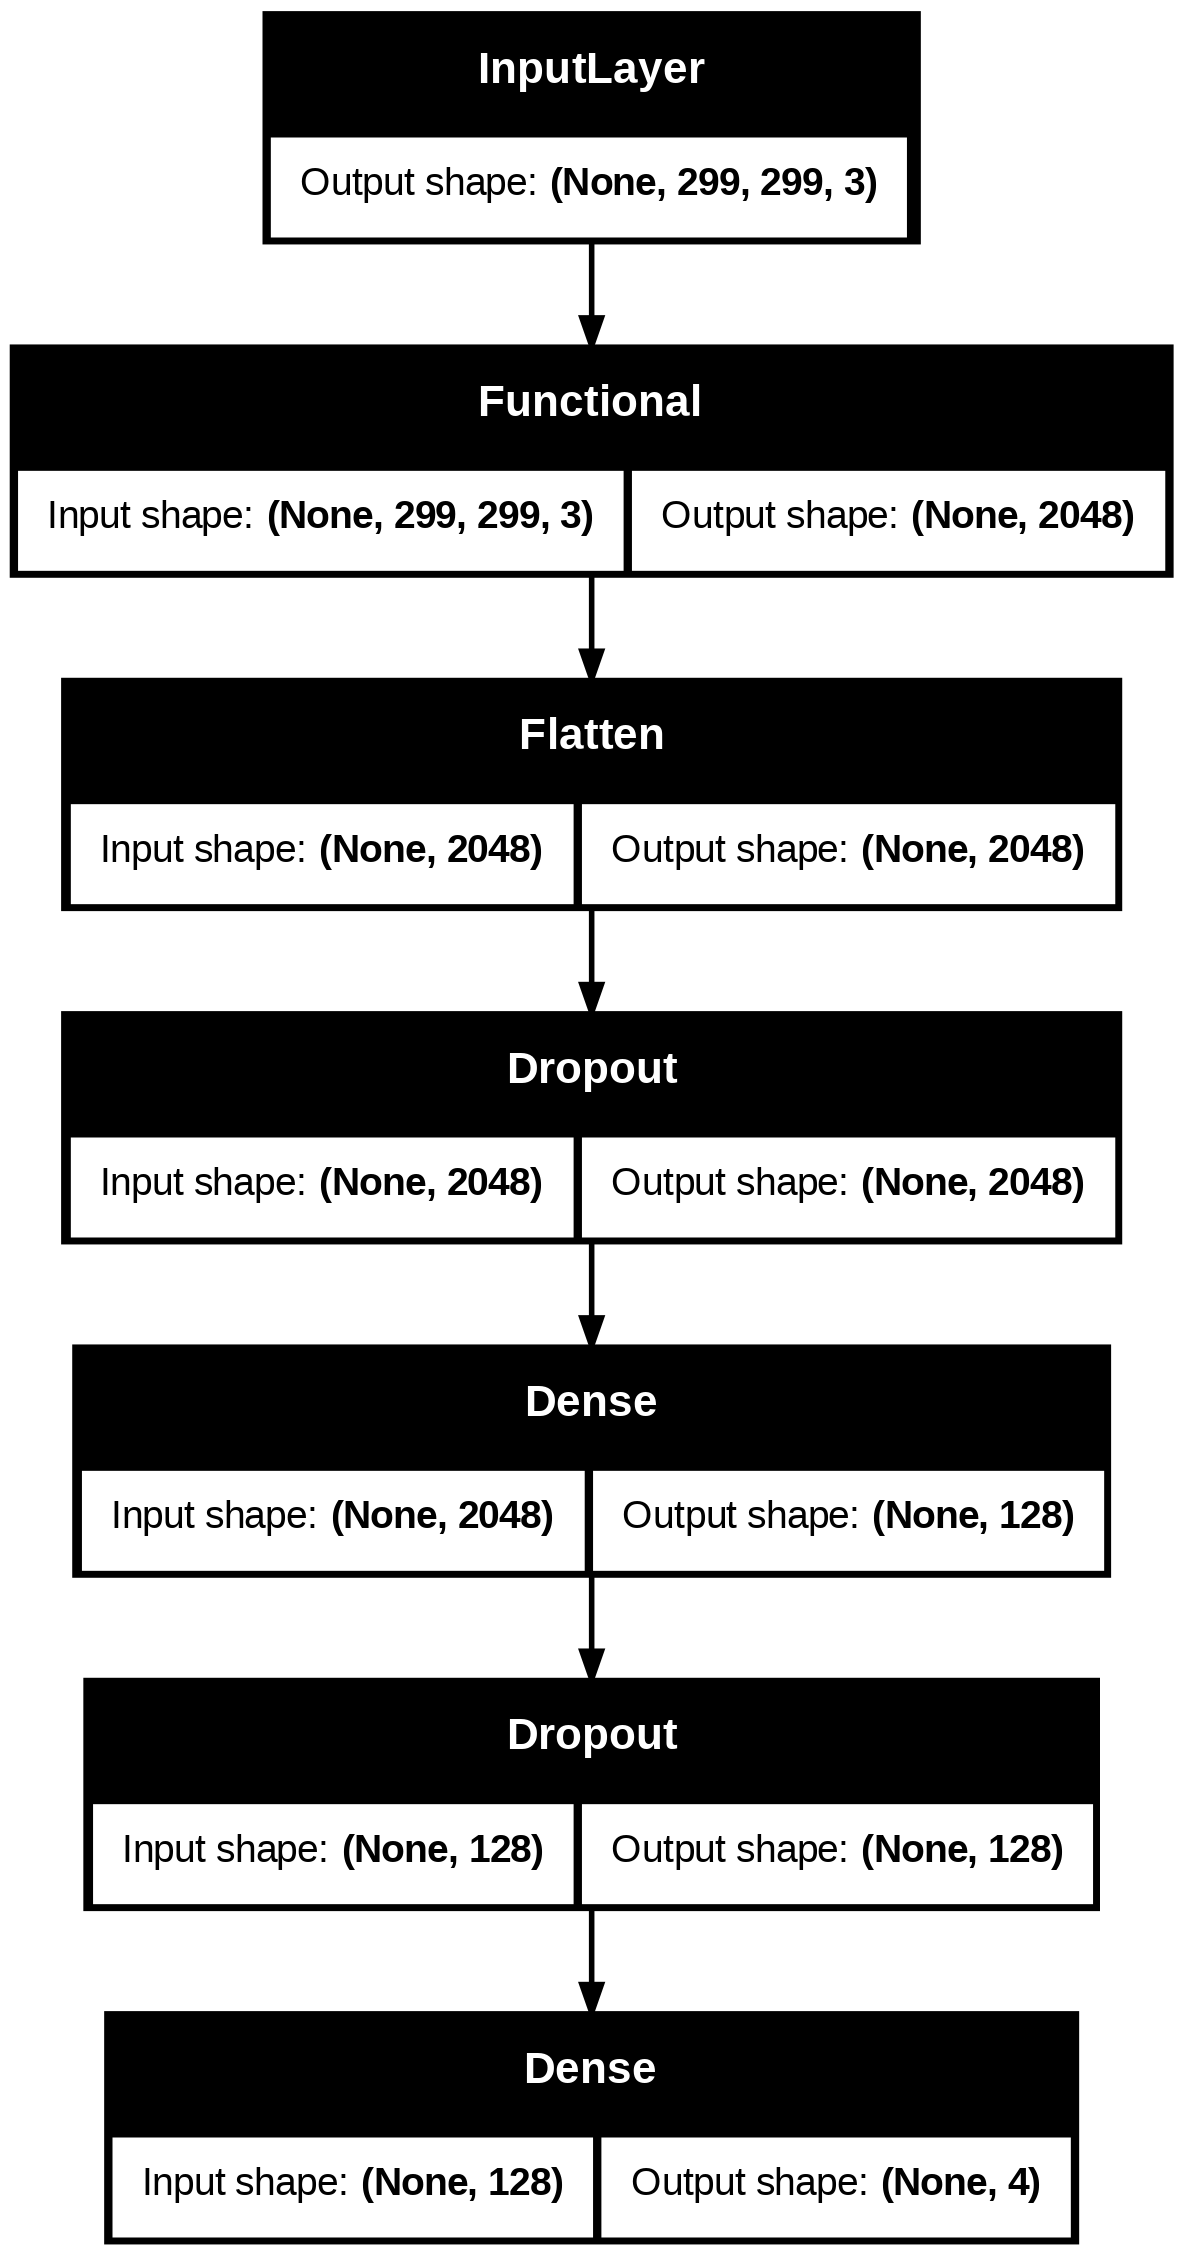

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Entrenamiento

In [ ]:
hist = model.fit(tr_gen,
epochs=15,
validation_data=valid_gen,
shuffle= False)

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 2410s 7s/step - accuracy: 0.7362 - loss: 0.7659 - precision: 0.8228 - recall: 0.5960 - val_accuracy: 0.9267 - val_loss: 0.2026 - val_precision: 0.9267 - val_recall: 0.9267
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 137s 384ms/step - accuracy: 0.9757 - loss: 0.0809 - precision: 0.9770 - recall: 0.9736 - val_accuracy: 0.9802 - val_loss: 0.0679 - val_precision: 0.9801 - val_recall: 0.9786
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 396ms/step - accuracy: 0.9866 - loss: 0.0453 - precision: 0.9875 - recall: 0.9850 - val_accuracy: 0.9740 - val_loss: 0.0940 - val_precision: 0.9740 - val_recall: 0.9740
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 397ms/step - accuracy: 0.9913 - loss: 0.0288 - precision: 0.9927 - recall: 0.9910 - val_accuracy: 0.9802 - val_loss: 0.0766 - val_precision: 0.9802 - val_recall: 0.9802
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 142s 397ms/step - accuracy: 0.9955 - loss: 0.0153 - precision: 0.9956 - recall: 0.9954 - val_accuracy: 0.9

In [ ]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

### Gráficas de Precisión y Pérdida

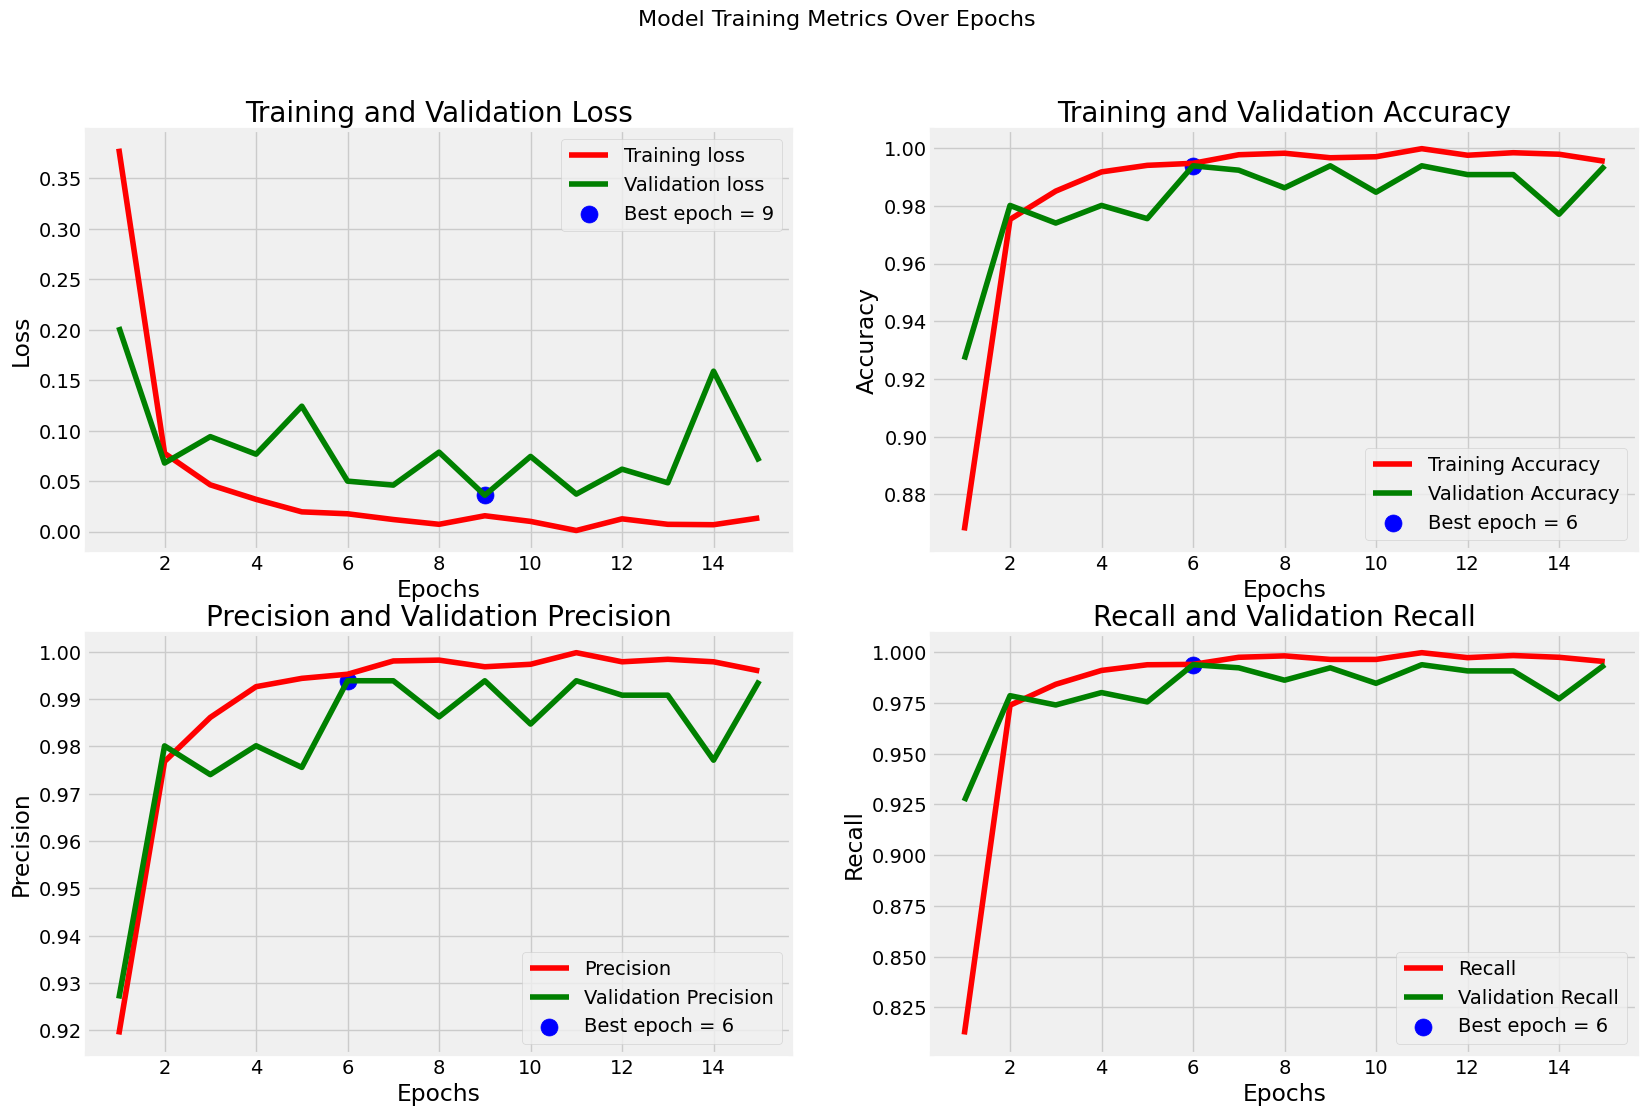

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

## Pruebas y Evaluación

### Evaluación

In [ ]:
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9991 - loss: 0.0061 - precision: 0.9995 - recall: 0.9991
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9954 - loss: 0.0386 - precision: 0.9954 - recall: 0.9954
41/41 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.9902 - loss: 0.0331 - precision: 0.9902 - recall: 0.9902
Train Loss:  0.003416304476559162
Train Accuracy:  0.9994747638702393
--------------------
Validation Loss:  0.06955178081989288
Validation Accuracy:  0.9938931465148926
--------------------
Test Loss:  0.03161923587322235
Test Accuracy:  0.9923780560493469


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step


### Matriz de Confusión

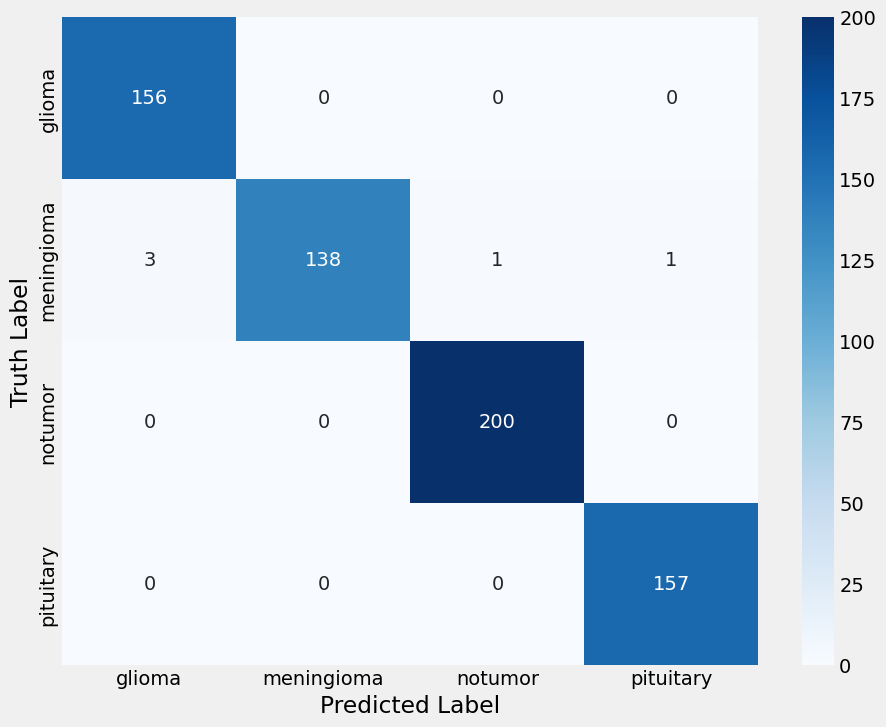

In [ ]:
# confusion_matrix es una función que calcula la matriz de confusión comparando
# las etiquetas verdaderas (ts_gen.classes) con las etiquetas predichas (y_pred).

# ts_gen.classes contiene las etiquetas verdaderas de las imágenes del conjunto de prueba.
# y_pred es una lista de etiquetas predichas por el modelo para las mismas imágenes.
# La matriz de confusión resultante cm es una tabla que resume el rendimiento
# de un algoritmo de clasificación. Cada fila representa las instancias en una clase real
# y cada columna las instancias en una clase predicha.


cm = confusion_matrix(ts_gen.classes, y_pred)

# Se crea una lista labels que contiene las claves de class_dict. Estas claves
# representan las etiquetas de clase utilizadas para identificar las filas y
# columnas de la matriz de confusión.

labels = list(class_dict.keys())

# Se crea una nueva figura con un tamaño de 10x8 pulgadas para visualizar la matriz de confusión.

plt.figure(figsize=(10,8))

# sns.heatmap se utiliza para visualizar la matriz de confusión como un mapa de calor.
# cm es la matriz de confusión que se va a visualizar.
# annot=True añade anotaciones a cada celda de la matriz con el valor correspondiente.
# fmt='d' indica que los valores en las celdas se formatean como enteros.
# cmap='Blues' establece el esquema de colores del mapa de calor a una escala de azules.

# xticklabels=labels y yticklabels=labels establecen las etiquetas de los ejes x e y utilizando
# la lista de etiquetas definida anteriormente.

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted Label') y plt.ylabel('Truth Label') añaden etiquetas a los ejes x e y
# de la figura, respectivamente. Estas etiquetas indican que las columnas representan las etiquetas
# predichas y las filas las etiquetas verdaderas.

plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')

# plt.show() muestra la figura con el mapa de calor de la matriz de confusión.

plt.show()

### Classification Report

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       156
           1       1.00      0.97      0.98       143
           2       1.00      1.00      1.00       200
           3       0.99      1.00      1.00       157

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



### Prueba

In [ ]:
# Función para predecir el tipo de tumor con base en la ruta donde se
# encuentra la imagen

def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image

  # La variable label se crea como una lista que contiene todas las claves del
  # diccionario class_dict, representando las etiquetas de clase posibles.

  label = list(class_dict.keys())

  # Se crea una nueva figura para la visualización de gráficos con un tamaño
  # de 12x12 pulgadas.

  plt.figure(figsize=(12, 12))

  # Se abre la imagen especificada por la ruta img_path utilizando la biblioteca PIL.

  img = Image.open(img_path)

  # La imagen se redimensiona a 299x299 píxeles, tamaño de entrada específico
  # para la red Xception

  resized_img = img.resize((299, 299))

  # La imagen redimensionada se convierte en un arreglo de NumPy. Esto es útil
  # para realizar manipulaciones numéricas en la imagen.

  img = np.asarray(resized_img)

  # Se expande la dimensión del arreglo de imagen, agregando una nueva dimensión
  # en el eje 0. Esto convierte la imagen de un formato 3D (altura, anchura, canales)
  # a un formato 4D (1, altura, anchura, canales).

  # La expansión de dimensiones es necesaria porque los modelos de aprendizaje profundo
  # suelen requerir un lote de imágenes como entrada, incluso si solo se está prediciendo
  # una imagen.

  img = np.expand_dims(img, axis=0)

  # Se usa el modelo preentrenado (model) para predecir la clase de la imagen procesada.
  # El resultado predictions es una matriz donde cada elemento representa la probabilidad
  # de cada clase.

  predictions = model.predict(img)

  # probs se convierte en una lista de probabilidades para cada clase.
  # labels contiene las etiquetas de clase correspondientes.

  probs = list(predictions[0])
  labels = label

  # Se crea un gráfico con dos subgráficos (2 filas, 1 columna).

  plt.subplot(2, 1, 1)

  # El primer subgráfico muestra la imagen redimensionada.
  plt.imshow(resized_img)

  # El segundo subgráfico muestra un gráfico de barras horizontal (barh)
  # de las probabilidades para cada clase.

  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)

  # Se etiqueta el eje x con "Probability".

  plt.xlabel('Probability', fontsize=15)

  # ax = plt.gca() se usa para obtener el eje donde se dibuja el gráfico de barras
  # horizontal.

  ax = plt.gca()

  # ax.bar_label(bars, fmt='%.2f') agrega etiquetas a cada barra, mostrando las
  # probabilidades con dos decimales.

  ax.bar_label(bars, fmt = '%.2f')

  # Finalmente, se muestra la figura completa con la imagen y el gráfico de
  # probabilidades.

  plt.show()

### Ejemplos de Predicción

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


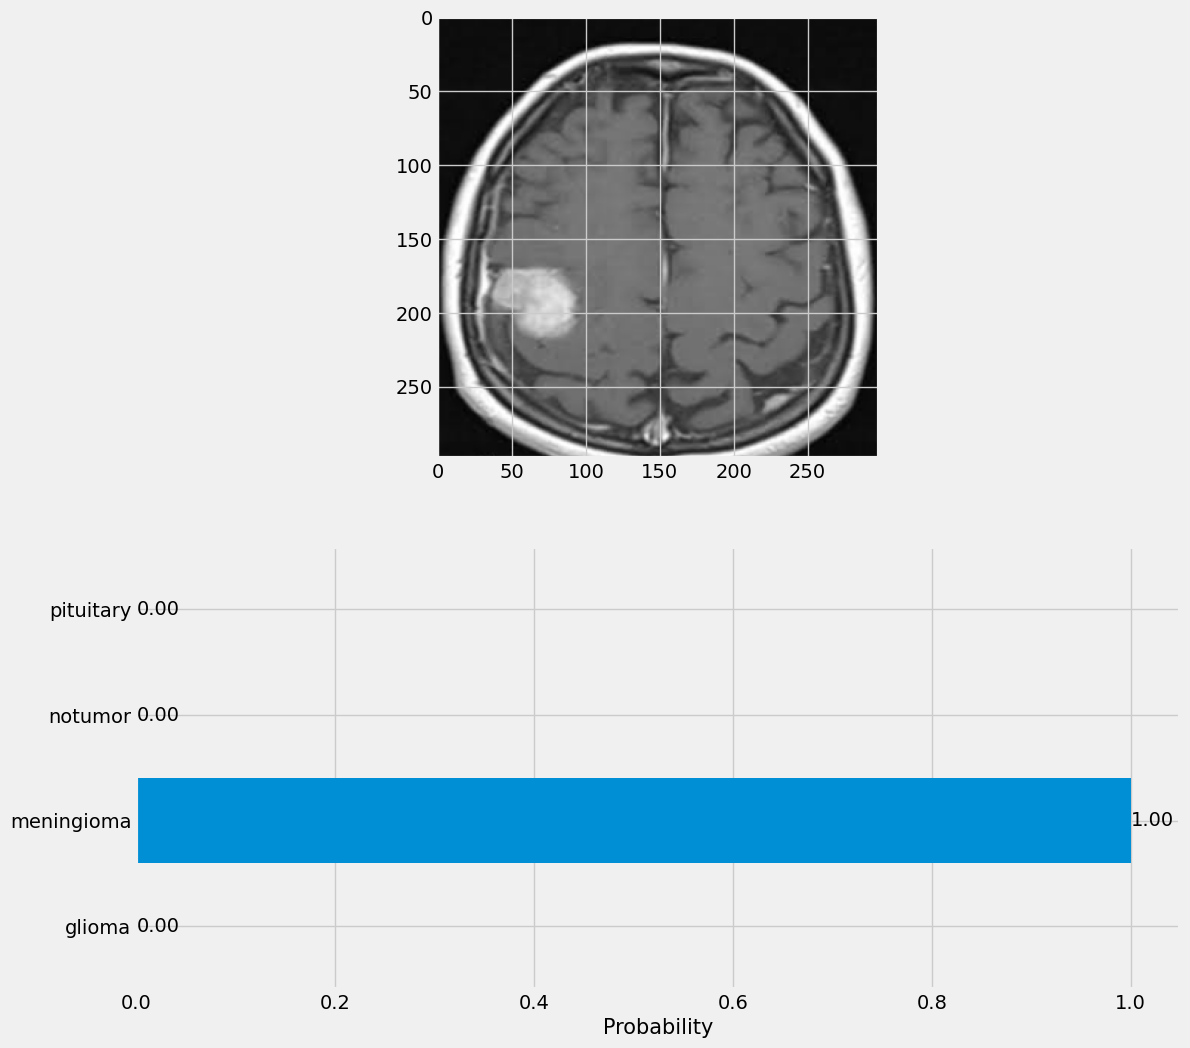

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/meningioma/Te-me_0023.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


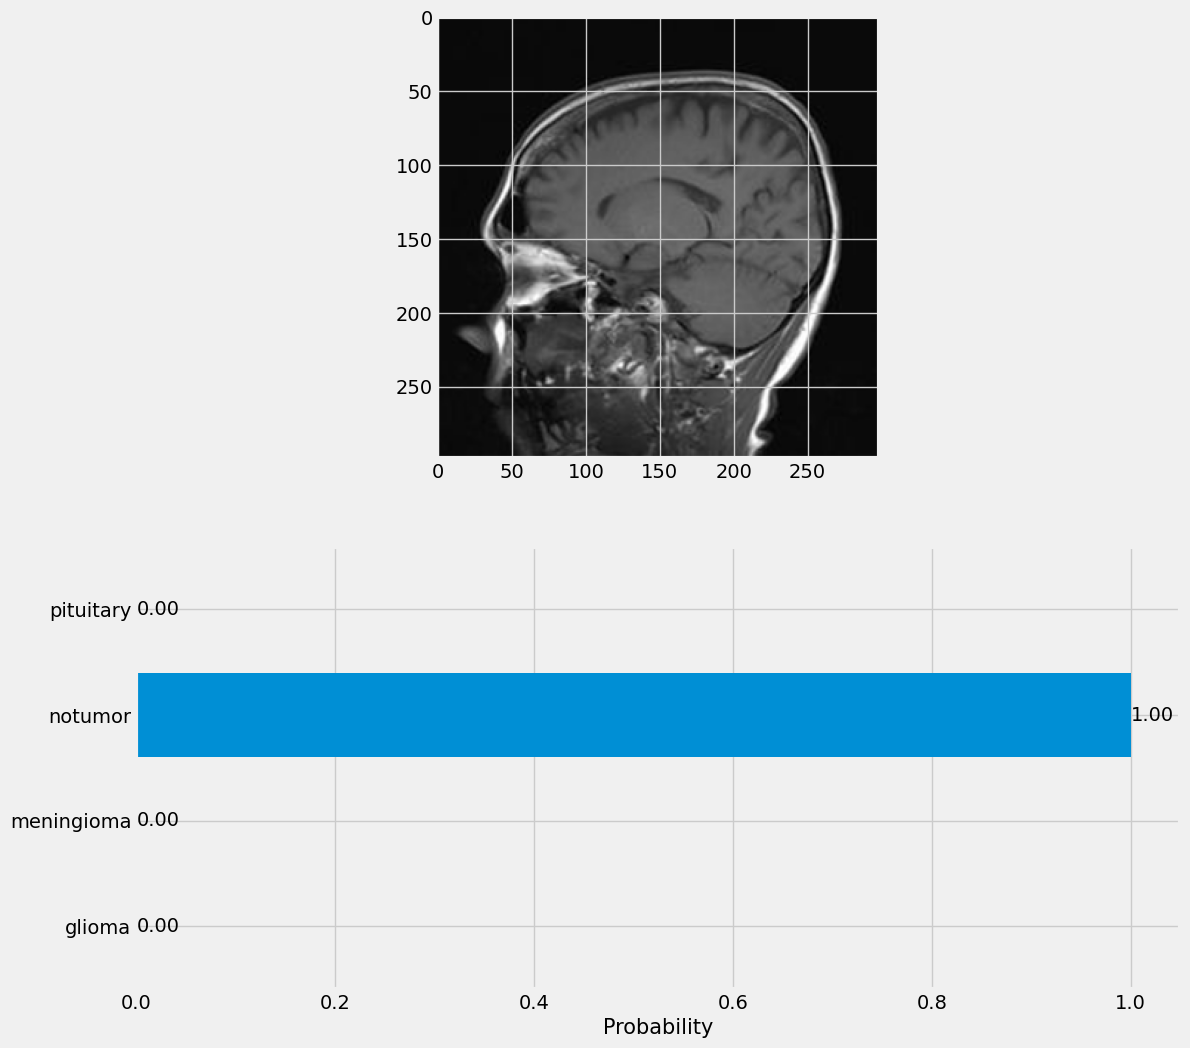

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/notumor/Te-no_0015.jpg")